In [ ]:
from torchvision.models import resnet50
from torchvision.datasets import CIFAR10
from torchvision import transforms
from copy import deepcopy
from math import inf
from google.colab import files
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import gc

In [ ]:
class Settings:
  # Number of samples chosen uniformly at random from validation (test) set
  # to purturb the model further on. Originally, it was set to 128 in all experiments (K=128).
  random_ensemble_samples = 128
  assert random_ensemble_samples == 128

  # Number of models in the final ensemble (S = [15, 30])
  ensemble_count = 30
  assert ensemble_count in [15, 30]

  validation_percentage = 1 / 5
  assert validation_percentage <= 1 / 2

  # ResNet50 train epoch count
  training_epochs = 50

  learning_rate = 0.01
  batch_size = 512

In [ ]:
base_model = resnet50(pretrained=True)

base_model.fc = torch.nn.Linear(
  base_model.fc.in_features,
  10
)

# Freeze convolutional layers for fine-tunning, however when making the ensemble we
# send them back in business.
for param in base_model.parameters():
  param.requires_grad = False

# Allow the classifier to be trained
for param in base_model.fc.parameters():
  param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5),
    )
])

train_dataset = CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

test_dataset_size = len(test_dataset)
validation_dataset_size = int(test_dataset_size * Settings.validation_percentage)
test_dataset_size = test_dataset_size - validation_dataset_size

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [validation_dataset_size, test_dataset_size])

len(train_dataset), len(test_dataset), len(validation_dataset)

Files already downloaded and verified
Files already downloaded and verified


(50000, 8000, 2000)

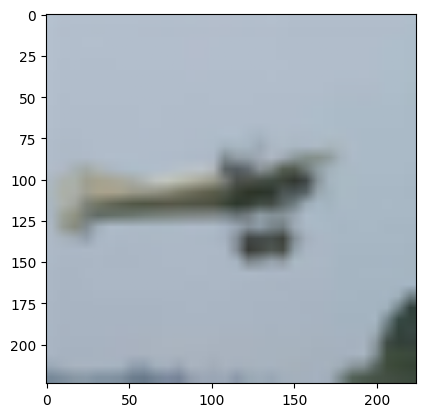

In [ ]:
image = test_dataset[100][0]
image = image / 2 + 0.5
image = np.transpose(image, (1, 2, 0))

plt.imshow(image)
plt.show()

# Fine-Tunning ResNet50 On CIFAR10

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=Settings.batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=Settings.batch_size, shuffle=False)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    base_model.parameters(),
    lr=Settings.learning_rate
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=10)

best_model = None
best_accuracy = -inf

In [ ]:
for epoch in range(Settings.training_epochs):
  base_model.train()
  training_loss = 0.0

  for images, labels in train_dataloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = base_model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()
    training_loss += loss.item()

  # Evaluate the model at the end of each epoch

  base_model.eval()
  test_loss = 0
  correct = 0
  with torch.inference_mode():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      test_predictions = base_model(images)
      batch_loss = criterion(test_predictions, labels)
      test_loss += batch_loss.item()
      _, test_predictions = torch.max(test_predictions, 1)
      correct += (test_predictions == labels).float().sum()

  accuracy = 100 * correct / len(test_dataset)

  # Save the best model based on the accuracy on the test images

  if accuracy > best_accuracy:
    best_model = deepcopy(base_model)
    best_accuracy = accuracy

  scheduler.step()
  print(f"Epoch number {epoch + 1}: loss={training_loss} test_loss={test_loss} accuracy={accuracy} lr={scheduler.get_last_lr()}.")

torch.save(best_model.state_dict(), "./resnet50-CIFAR10-classifier-only-25epochs.model")
files.download("./resnet50-CIFAR10-classifier-only-25epochs.model")

Epoch number 1 finished with a training loss of 169.33219411969185 and an accuracy of 77.7750015258789.
Epoch number 2 finished with a training loss of 57.4844229221344 and an accuracy of 79.47500610351562.
Epoch number 3 finished with a training loss of 54.27012547850609 and an accuracy of 80.82500457763672.
Epoch number 4 finished with a training loss of 53.48809051513672 and an accuracy of 80.6500015258789.
Epoch number 5 finished with a training loss of 51.73280122876167 and an accuracy of 80.37500762939453.
Epoch number 6 finished with a training loss of 51.93978136777878 and an accuracy of 79.5.
Epoch number 7 finished with a training loss of 49.906372010707855 and an accuracy of 81.18750762939453.
Epoch number 8 finished with a training loss of 46.83189344406128 and an accuracy of 82.68750762939453.
Epoch number 9 finished with a training loss of 48.05775761604309 and an accuracy of 81.93750762939453.
Epoch number 10 finished with a training loss of 46.40218672156334 and an accu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ensemble_learning_rate = scheduler.get_last_lr()[0]
ensemble_learning_rate

0.0001

# Creating The Ensemble

In [ ]:
ensemble_learning_rate = 0.0001
temporary_model = resnet50(pretrained=False)
temporary_model.fc = torch.nn.Linear(
  temporary_model.fc.in_features,
  10
)
temporary_model.load_state_dict(torch.load("./resnet50-CIFAR10-classifier-only-50epochs.model"))
temporary_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
models = []

# Unfreeze the CNN layers for perturbation
for param in temporary_model.parameters():
  param.requires_grad = True

for _ in range(Settings.ensemble_count):
  copied_model = deepcopy(temporary_model)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(copied_model.parameters(), lr=ensemble_learning_rate)

  indices = random.sample(range(len(validation_dataset)), Settings.random_ensemble_samples)
  batch   = torch.utils.data.Subset(validation_dataset, indices)
  batch   = torch.utils.data.DataLoader(batch, batch_size=32, shuffle=False)

  copied_model.train()

  for images, labels in batch:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    predictions = copied_model(images)
    loss = criterion(predictions, labels)
    loss.backward()
    optimizer.step()

  copied_model.eval()
  test_loss = 0
  correct = 0
  with torch.inference_mode():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      test_predictions = copied_model(images)
      batch_loss = criterion(test_predictions, labels)
      test_loss += batch_loss.item()
      _, test_predictions = torch.max(test_predictions, 1)
      correct += (test_predictions == labels).float().sum()

  accuracy = 100 * correct / len(test_dataset)
  models.append(copied_model)
  print(f"A model with test accuracy of {accuracy} was added to the ensemble.")

A model with test accuracy of 72.80000305175781 was added to the ensemble.
A model with test accuracy of 69.4375 was added to the ensemble.
A model with test accuracy of 75.0 was added to the ensemble.
A model with test accuracy of 76.76250457763672 was added to the ensemble.
A model with test accuracy of 74.16250610351562 was added to the ensemble.


KeyboardInterrupt: 

In [ ]:
for i, model in enumerate(models):
  torch.save(model.state_dict(), f"./ensemble/model-{i}.model")